In [1]:
import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import re
import swifter

from sklearn import preprocessing
from sklearn.model_selection import cross_validate
import lightgbm as lgbm

from settings import file_names

In [2]:
df = pd.read_csv(file_names['toronto_reviews_without_text'], index_col=[0])
df_users = pd.read_csv(file_names['toronto_users'])
df_biz = pd.read_csv(file_names['toronto_businesses'], index_col=[0])

In [3]:
# Helper Functions
# A helper funtion to assign communities
def assign_communities(community, df, name):
    # Create a new df
    df = df.copy()
    
    # Create a new column for communities
    df[name] = 0
    
    for i, com in enumerate(community):
        
        # Get node indices
        com = G.vs[com]['name']
        
        # Convert strings to integers
        com = [int(x) for x in com]
        
        mask = df['user_id'].isin(com)
        df.loc[mask, name] = i 
        
    return df

# 1. Feature Engineering

## 1.1 Encode IDs

In [4]:
le = {}
le['user'] = preprocessing.LabelEncoder()
le['business'] = preprocessing.LabelEncoder()

# Encode the review table
df['user_id'] = le['user'].fit_transform(df['user_id'])
df['business_id'] = le['business'].fit_transform(df['business_id'])

# Encode the business table
df_biz['business_id'] = le['business'].transform(df_biz['business_id'])

# Encode, filter and transform the user table - only friendships between two toronto residents remain
df_users['friends'] = df_users['friends'].str.split()
df_users = df_users.explode('friends')
df_users = df_users[df_users['user_id'].isin(le['user'].classes_)]
df_users = df_users[df_users['friends'].isin(le['user'].classes_)]
df_users['user_id'] = le['user'].transform(df_users['user_id'])
df_users['friends'] = le['user'].transform(df_users['friends'])

## 1.2 Business

In [5]:
# Select relevant columns
cols = ['business_id', 'latitude', 'longitude', 'stars', 'review_count', 'attributes',
       'categories']
df_biz = df_biz[cols]

In [6]:
# Clean the attributes column - Undone
df_biz['attributes'] = df_biz['attributes'].map(eval, na_action='ignore')
df_biz = df_biz.drop('attributes', axis=1)

In [7]:
# Clean the categories column
df_biz['categories'] = df_biz['categories'].str.split(', ')

# Keep only categories that have at least 100 samples
temp = df_biz.pop('categories').explode()
temp = pd.crosstab(temp.index, temp)
mask = temp.sum(axis=0)
mask = (mask[mask>=100]).index
df_biz = pd.concat([df_biz, temp[mask]], axis=1)

## 1.3 Users

In [8]:
# Constrcut a user graph
G = ig.Graph.TupleList(df_users.values)

In [9]:
# Community Detection - infomap
c_infomap = G.community_infomap()
df_users = pd.DataFrame({'user_id':G.vs['name']})
df_users = assign_communities(c_infomap, df_users, 'infomap')

## 1.4 Reviews

In [10]:
# Read the saved review graph
G = ig.read('graph.graphml',format="graphml")

In [11]:
# Some graph attributes
att = {'weighted_centrality':G.strength(weights='weight'),
       'eigenvector_centrality':G.eigenvector_centrality(weights='weight'),
       'pagerank': G.pagerank(weights='weight')}

att = pd.DataFrame(att)
att['index'] = G.vs['id']
att['index'] = pd.to_numeric(att['index'])
df = df.merge(att, left_on='business_id', right_on='index', how='left')
df = df.merge(att, left_on='user_id', right_on='index', how='left')

df = df.drop(['index_y', 'index_x'], axis=1)

## 1.5 Join everything together

In [12]:
data = df.merge(df_biz, on='business_id', how='left')
data = data.merge(df_users, on='user_id', how='left')

In [13]:
# Shuffle the dataframe
data = data.sample(frac=1)

In [14]:
# Separate the training and validation set
data_train = data.iloc[:400000]
data_val = data.iloc[400000:]

data_train = data_train.sort_values('user_id')
data_val = data_val.sort_values('user_id')

## 1.6 Create X and y

In [26]:
X_train = data_train.drop(['date', 'rating', 'user_id', 'longitude', 'latitude'], axis=1)
y_train = data_train['rating']
q_train = data_train.groupby('user_id')['rating'].count().values

X_val = data_val.drop(['date', 'rating', 'user_id', 'longitude', 'latitude'], axis=1)
y_val = data_val['rating']
q_val = data_val.groupby('user_id')['rating'].count().values

# 2. Modeling

## 2.1 Restaurant Ranker

In [31]:
model = lgbm.LGBMRanker(n_estimators=500, n_jobs=-1, learning_rate=0.1, silent=True)

In [32]:
model.fit(X_train, y_train, group=q_train, eval_set=[(X_val, y_val)], eval_group=[q_val], eval_metric='auc')

[1]	valid_0's auc: 1	valid_0's ndcg@1: 0.934917
[2]	valid_0's auc: 1	valid_0's ndcg@1: 0.935195
[3]	valid_0's auc: 1	valid_0's ndcg@1: 0.935503
[4]	valid_0's auc: 1	valid_0's ndcg@1: 0.935647
[5]	valid_0's auc: 1	valid_0's ndcg@1: 0.935955
[6]	valid_0's auc: 1	valid_0's ndcg@1: 0.935926
[7]	valid_0's auc: 1	valid_0's ndcg@1: 0.935869
[8]	valid_0's auc: 1	valid_0's ndcg@1: 0.935878
[9]	valid_0's auc: 1	valid_0's ndcg@1: 0.936082
[10]	valid_0's auc: 1	valid_0's ndcg@1: 0.936219
[11]	valid_0's auc: 1	valid_0's ndcg@1: 0.936389
[12]	valid_0's auc: 1	valid_0's ndcg@1: 0.936165
[13]	valid_0's auc: 1	valid_0's ndcg@1: 0.936357
[14]	valid_0's auc: 1	valid_0's ndcg@1: 0.936439
[15]	valid_0's auc: 1	valid_0's ndcg@1: 0.936433
[16]	valid_0's auc: 1	valid_0's ndcg@1: 0.936466
[17]	valid_0's auc: 1	valid_0's ndcg@1: 0.936566
[18]	valid_0's auc: 1	valid_0's ndcg@1: 0.936651
[19]	valid_0's auc: 1	valid_0's ndcg@1: 0.936627
[20]	valid_0's auc: 1	valid_0's ndcg@1: 0.93676
[21]	valid_0's auc: 1	valid_0'

LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

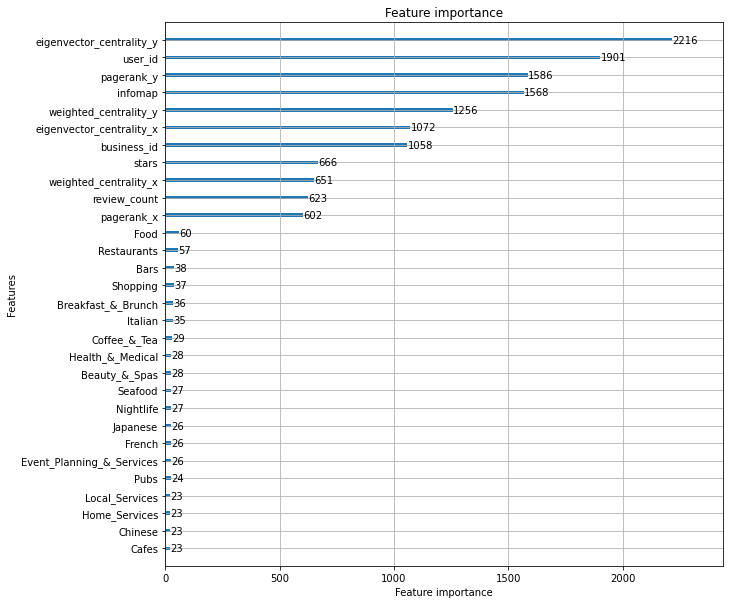

In [33]:
# Feature Importance
lgbm.plot_importance(model, figsize=(10,10), max_num_features=30)

## 2.2 Rating Predictions

In [34]:
model = lgbm.LGBMClassifier(n_estimators=300, n_jobs=-1, learning_rate=0.1, silent=True)

In [35]:
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [38]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.51431
Validation Accuracy: 0.4985131978602805


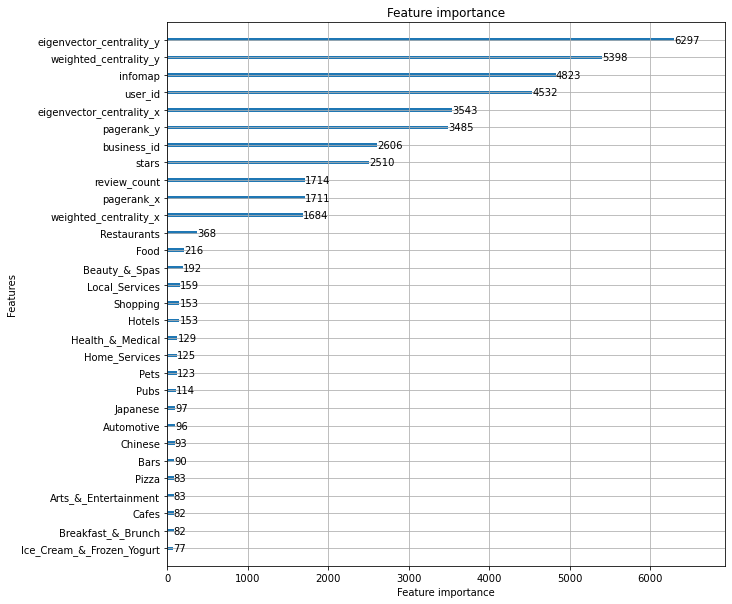

In [37]:
# Feature Importance
lgbm.plot_importance(model, figsize=(10,10), max_num_features=30)